In [2]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
image = Image.open("../img/horse.jpg").convert("L")
image_np = np.array(image)

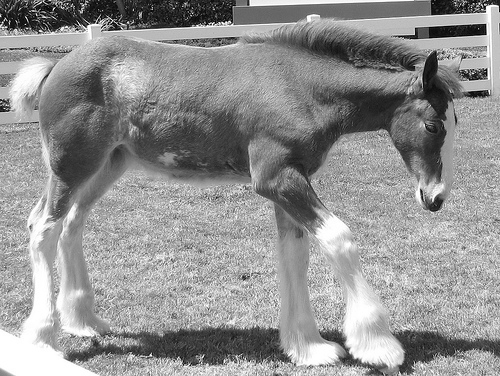

In [4]:
image

### 图像直方图

In [5]:
def get_histogram(image):
    #frequency:频数
    frequency = np.zeros((256))
    h,w = image.shape
    #遍历图像计算灰度出现次数
    for i in range(h):
        for j in range(w):
            data = image[i][j]
            frequency[data] += 1
    return np.int32(frequency)

In [6]:
def draw_hist(frequency):
    plt.bar([i for i in range(len(frequency))],frequency)
    plt.xlabel("pixel")
    plt.ylabel("frequency")
    plt.show()

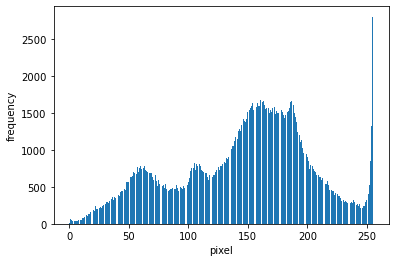

In [7]:
frequency = get_histogram(image_np)
draw_hist(frequency)

### 图像直方分段图线性拉伸
![](2021-12-14-16-00-45.png)

In [8]:
def hist_stretch(image,a,b,c,d):
    h,w = image.shape
    out = np.zeros((h,w),dtype = np.uint8)
    for i in range(h):
        for j in range(w):
            data = image[i][j]
            #分情况讨论
            if data in range(0,a):
                out[i][j] = int(data*(c/a))
            elif data in range(a,b):
                out[i][j] = int((d-c)/(b-a)*(data-a)+c)
            else:
                out[i][j] = int((255-d)/(255-b)*(data-b)+d)
    return out

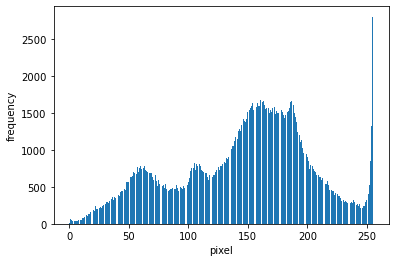

In [9]:
freq1 = get_histogram(image_np)
draw_hist(freq1)

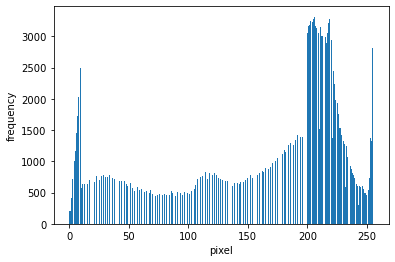

In [10]:
image_np_2 = hist_stretch(image_np,50,150,10,200)
freq2 = get_histogram(image_np_2)
draw_hist(freq2)

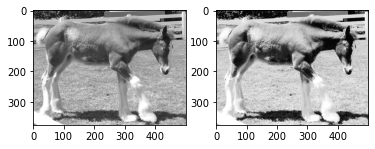

In [11]:
plt.subplot(121)
plt.imshow(image_np,'gray')
plt.subplot(122)
plt.imshow(Image.fromarray(image_np_2),'gray')

### 直方图均衡化

In [11]:
def equalization(image):
    #计算概率密度
    h,w = image.shape
    num_px = h*w
    freq1 = get_histogram(image)
    #频率
    prob = freq1/num_px
    prob2 = []
    for i in range(len(freq1)-1):
        prob2.append(sum(prob[:i+1]))
    #最后一个肯定是1
    prob2.append(1)
    
    #像素值替换
    out = np.zeros((h,w),dtype = np.uint8)
    freq2 = np.round(np.array(prob2)*255)
    for i in range(h):
        for j in range(w):
            data = image[i][j]
            out[i][j] = freq2[data]
    return out


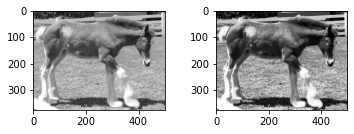

In [12]:
image_np_3 = equalization(image_np)
plt.subplot(221)
plt.imshow(image_np,'gray')
plt.subplot(222)
plt.imshow(Image.fromarray(image_np_3),'gray')


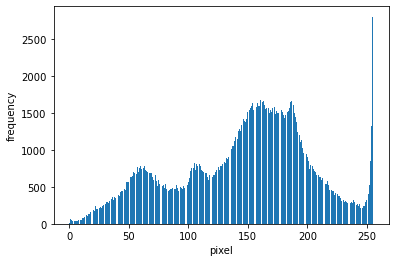

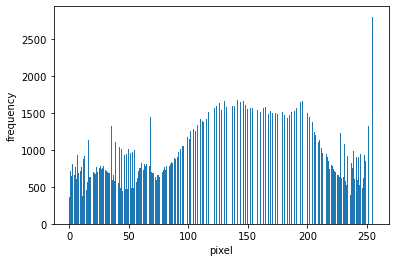

In [13]:
draw_hist(get_histogram(image_np))
draw_hist(get_histogram(image_np_3))

### 频率滤波器

In [135]:
#输入图像和滤波掩膜
def frequency_filter(image,mask,mode = "low"):
    #图像快速傅里叶变换
    image_fft = np.fft.fft2(image)
    image_fft_shift = np.fft.fftshift(image_fft)
    #生成mask
    if mode == "low":
        pass
    if mode == "high":
        mask = 1 - mask
    out = image_fft_shift.copy()
    #mask与原图位运算
    out = out * mask
    #傅里叶反变换
    out = np.fft.ifftshift(out)
    out = np.fft.ifft2(out)
    out = np.clip(out,0,255)
    out = np.abs(out).astype(np.uint8)
    return out 

In [136]:
#低通滤波器
def low_pass_mask(image,threshold):
    h,w = image.shape
    mask = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            #计算当前像素与图像中心距离
            d = np.sqrt((i-h//2)**2+(j-w//2)**2)
            if d <=threshold:
                mask[i][j] = 1
    return mask

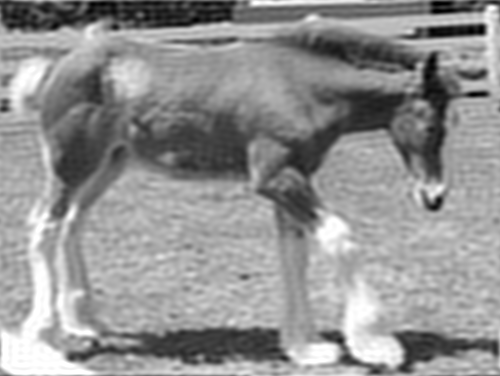

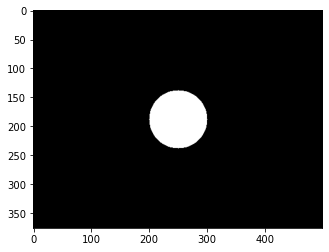

In [137]:
mask = low_pass_mask(image_np,50)
out = frequency_filter(image_np,mask)
plt.imshow(mask,"gray")
Image.fromarray(out)

In [138]:
#巴通沃斯滤波器
def butterworth_low_pass_mask(image,cut_off,butterworth_order):
    h,w = image.shape
    mask = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            #计算当前像素与图像中心距离
            d = np.sqrt((i-h//2)**2+(j-w//2)**2)
            mask[i][j] = 1.0/(1.0+(d/cut_off)**(2*butterworth_order))
    return mask

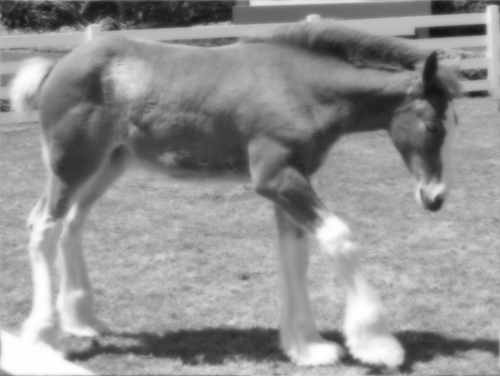

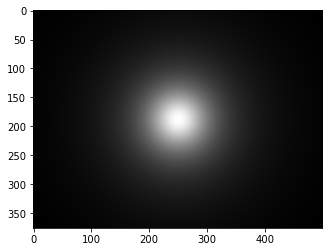

In [139]:
mask = butterworth_low_pass_mask(image_np,50,1)
out = frequency_filter(image_np,mask)
plt.imshow(mask,"gray")
Image.fromarray(out)

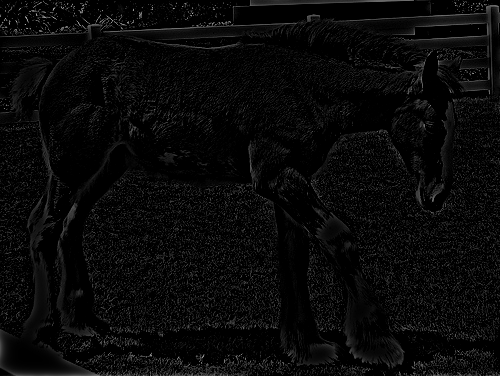

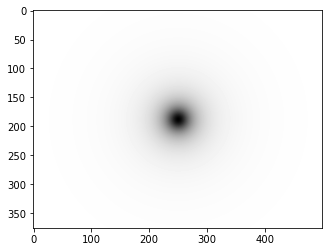

In [142]:
mask = butterworth_low_pass_mask(image_np,20,1)
out = frequency_filter(image_np,mask,mode = "high")
plt.imshow(1- mask,"gray")
Image.fromarray(out)